In [1]:
%cd ..

%config InlineBackend.figure_format = "retina"

/home/marco/contrast-gan-3D


In [2]:
from torch.optim import Adam
from torch.optim.lr_scheduler import MultiStepLR

from contrast_gan_3D.constants import DEFAULT_SEED, TRAIN_PATCH_SIZE
from contrast_gan_3D.data import utils as dset_utils
from contrast_gan_3D.model.discriminator import NLayerDiscriminator
from contrast_gan_3D.model.generator import ResnetGenerator
from contrast_gan_3D.trainer.Trainer import Trainer
from contrast_gan_3D.trainer.utils import create_train_folds

In [3]:
folds = create_train_folds(
    TRAIN_PATCH_SIZE,
    TRAIN_PATCH_SIZE,
    1,
    1,
    "/home/marco/data/ostia_final.xlsx",
    train_transform=dset_utils.make_train_transform(TRAIN_PATCH_SIZE),
    seed=DEFAULT_SEED,
)
train_loaders, val_loaders = folds[0]

In [4]:
lr = 2e-4
b1 = 5e-1
b2 = 0.999
milestones = [3, 7]
lr_gamma = 0.1
train_generator_every = 2
hu_loss_kwargs = {"bias": -1024, "factor": 600, "min_HU": 350, "max_HU": 450}
train_iterations = 10

generator = ResnetGenerator(6, 2, 16)
generator_optim = Adam(generator.parameters(), lr=lr, betas=(b1, b2))
generator_lr_scheduler = MultiStepLR(
    generator_optim, milestones=milestones, gamma=lr_gamma
)

discriminator = NLayerDiscriminator(1, 1, 3, 16)
discriminator_optim = Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))
discriminator_lr_scheduler = MultiStepLR(
    discriminator_optim, milestones=milestones, gamma=lr_gamma
)

trainer = Trainer(
    generator,
    discriminator,
    generator_optim,
    discriminator_optim,
    train_generator_every,
    run_id="pippo",
    generator_lr_scheduler=generator_lr_scheduler,
    discriminator_lr_scheduler=discriminator_lr_scheduler,
    device=4,
    **hu_loss_kwargs
)

[2024-02-13 16:07:51,704: INFO] Resuming run from '/home/marco/contrast-gan-3D/logs/model_checkpoints/pippo.pt' (contrast_gan_3D.trainer.Trainer:259)
[2024-02-13 16:07:51,724: INFO] Starting from iteration 0 (contrast_gan_3D.trainer.Trainer:269)


[2024-02-13 16:07:53,330: INFO] Using device: 4 (contrast_gan_3D.trainer.Trainer:125)


  0%|          | 0/12 [00:00<?, ?it/s]

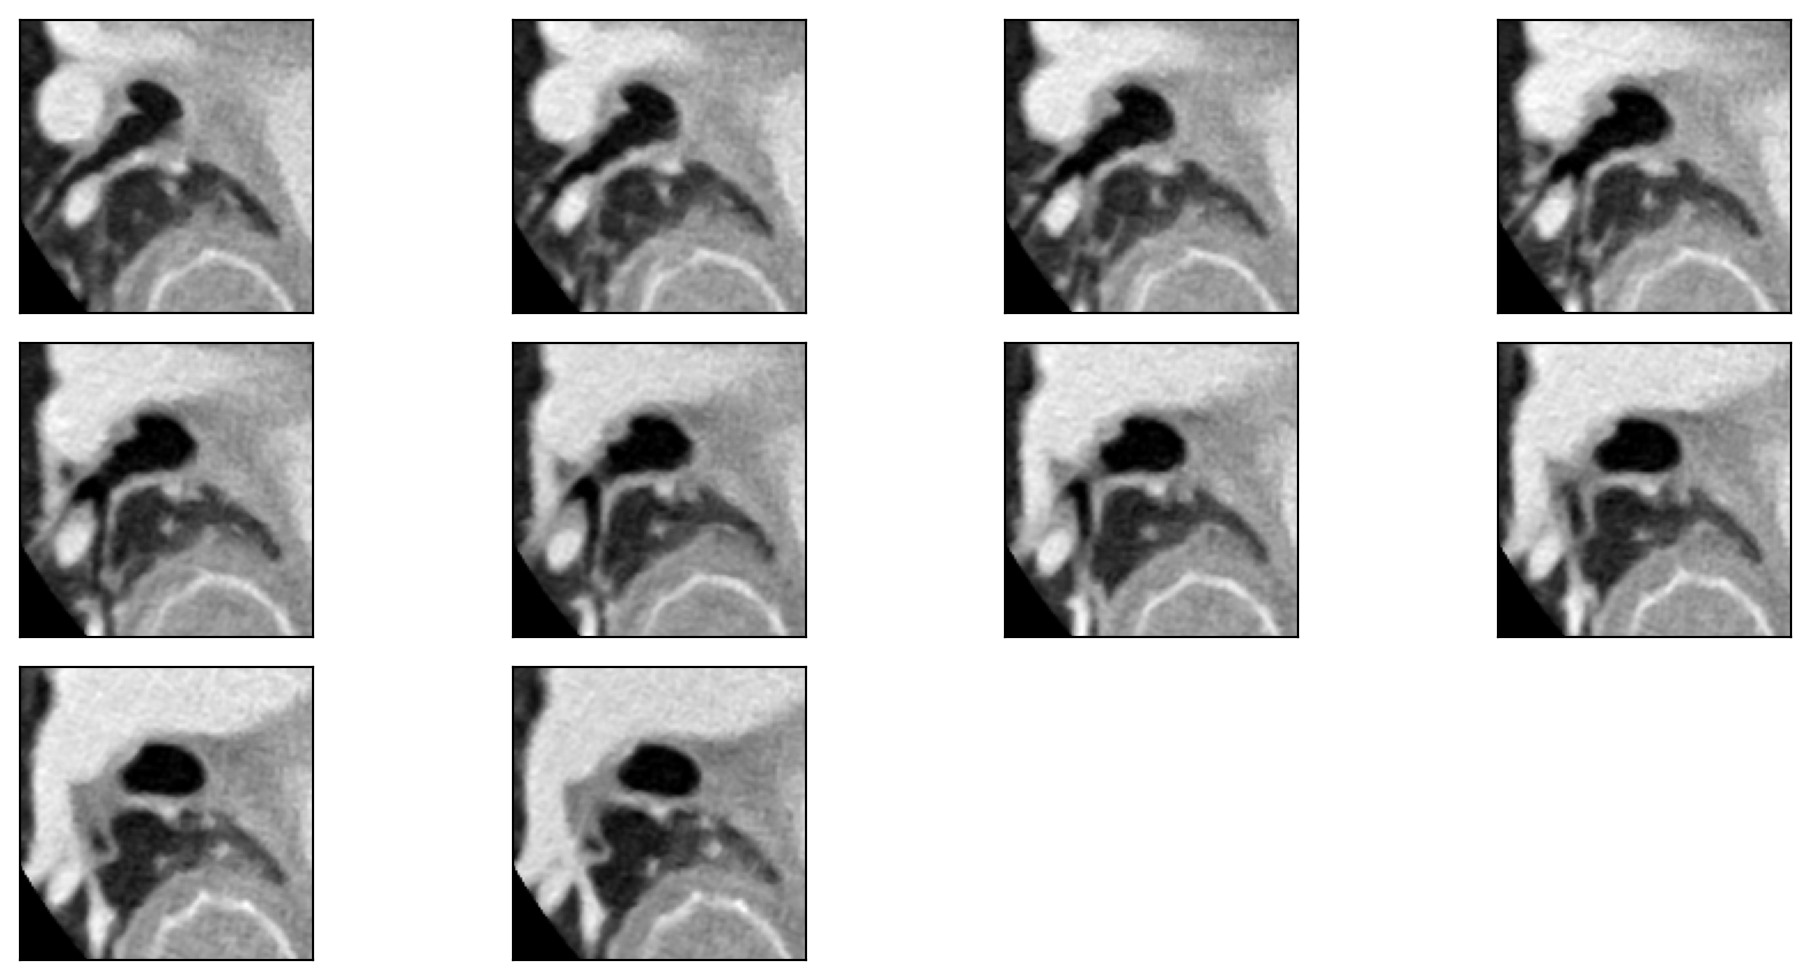

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:4 and cpu!

In [5]:
trainer.fit(12, train_loaders, val_loaders)